# Problem Statement

This notebook introduces one of the possible solutions to City Bike NYC problem. The main task is to distribute the bikes between the stations in an optimal way. The data contain list of stations, it's lacation and capacity. The demand and supply on each station was predited with ML algorithm. 

The initial code was built on [this repo](https://github.com/Gurobi/modeling-examples/tree/master/optimization101/bike_share). The authors developed the MO problem that minimize total loss of sale. In contrast, in this notebook I introduce the model that account for the distance between stations and minimizes the costs on the transportation. Additionaly, the loss of sale is either as as a constrain or as a second objective. 

The Optimization problem is solved using [Gurobi](https://www.gurobi.com/).

In [2]:
import numpy as np
import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy.spatial import distance_matrix

from gurobipy import GRB
import gurobipy as gp

## Data loading

The input data is the following:

- $N$ - the number of stations 
- $surplus_i$ ($N$) - the number of bikes, that will end the trip at station $i$ (supply, that depend from the users)
- $shortage_i$ ($N$) - the number of bikes, that will start the trip at station $i$ (demand)
- $capacity_i$ ($N$) - the maximum number of bikes, that cat stay at station $i$
- $C_{ij}$ ($N\times N$) - the cost of transportation from station $i$ to station $j$



The artificial data with only 2 stations to test and implement the optimization problem.

In [3]:
surplus = np.array([17,3])
shortage = np.array([3,7])
capacity = np.array([20,10])
cost = np.array([[0, 0.1],
                 [0.1, 0]])
N = len(surplus)

The real data with a few adjustments:

- add new station *Inventory* with 20 surplus (20 free bikes) and 0 shortage (no demand) and the biggest capacity - in case the space of some station will be filled. The location of *Inventory* is the mean of all location (assuming it is located in the center).
- use optimization for 1 timestamp ahead, for example 2 a.m. 2022/8/1
- the *cost* matrix will depend on the Euclidian distance between stations and is multiplied by 100

In [91]:
stations = pd.read_csv('top_stations.csv', index_col='station')
stations.loc["Inventory"] = [300, stations.lat.mean(), stations.lon.mean(), np.nan]
dist_matrix = distance_matrix(stations[["lat", "lon"]], stations[["lat", "lon"]])

capacity = stations.capacity.values
cost = dist_matrix*100  # we spent 100 dollar for 1 distance unit

stations_flow = pd.read_csv('stations_flow.csv')
stations_flow['datetime'] = pd.to_datetime(stations_flow['datetime'])
t = datetime.datetime(2022,8,1,2)
stations_flow = stations_flow[stations_flow['datetime'] == t]
stations_flow = stations_flow.set_index("station")
stations_flow = pd.concat([stations_flow, pd.DataFrame({"datetime":t,
                                                        "start_forecast":0,
                                                        "end_forecast":20}, index = ["Inventory"])])

surplus = stations_flow.loc[stations.index].end_forecast.values
shortage = stations_flow.loc[stations.index].start_forecast.values

N = len(surplus)

## Model setting

The unknown variable is the transition matrix $T_{ij}$. It contains the number of bikes that should be transfered from station $i$ to station $j$. $T_{ii}$ element shows how many bikes should stay at the same station. Since we deal with the absolute number, the type of variable is non-negative integer.

In [92]:
my_model = gp.Model('bikes')
T = my_model.addMVar((N,N), lb=0, ub=GRB.INFINITY, vtype=GRB.INTEGER, name = "transition matrix")

### General constraints

Capacity constraint - we cannot transfer to the station more bikes than it can store:
$$\sum_{i=1}^{N} T_{ij} \leq {capacity}_{j} \quad \text{for} \quad j=1\dots N  $$ 

Surplus constraint - we cannot transfer from the station more bikes than supply was:
$$\sum_{j=1}^{N} T_{ij} \leq {surplus}_{j} \quad \text{for} \quad i=1\dots N  $$ 

P.S. We assume that the supply is done only by customers. For this problem we do not have data about the initial number of bikes in the stations or inventory. If we want to add this information, we just need to create $new\_surplus = surplus + initial$, but the formulation of optimization problem will be the same. 

In [93]:
capacity_constr = my_model.addConstr((T.sum(axis = 0) <= capacity),
                                      name = "capacity_constr")
surplus_constr = my_model.addConstr((T.sum(axis = 1) == surplus),
                                     name = "surplus_constr")

### Option 1: cost objective and loss as a constraint

The main objective for our problem will be minimizing the cost:

$$\min \sum_{i=1}^N \sum_{j=1}^N T_{ij} C_{ij}$$

One of the option to fullfill the shortage is strict constraint that all the shortage must be satisfied:

$$\sum_{i=1}^{N} T_{ij} \geq {shortage}_{j} \quad \text{for} \quad j=1\dots N  $$ 

In [19]:
# Option 1: shortage must be satisfied
shortage_constr = my_model.addConstr((T.sum(axis = 0) >= shortage),
                                      name = "shortage_constr")

my_model.setObjective((T*cost).sum().sum(), GRB.MINIMIZE)

### Option 2: cost and loss objectives

We might consider an option when shortage can be not satisfied if the costs exceed the revenue. In this case, the loss from not satisfing the demand will be less than loss from satisfing it. This can be written with second objective - sum of losses:
$$ loss_j = {shortage}_{j} - \sum_{i=1}^{N} T_{ij} \quad \text{for} \quad j=1\dots N  $$
$$ \min \sum_{j=1}^{N} \max(loss_j, 0)$$ 

Also, we add new constant $loss\_cost$ - the money we lose per one unsatisfied bike ride. This constant can olso be considered as a weight for loss objective comparing to the cost objective. If $loss\_cost$ increse, the model will try to satisfy more shortage. The new objective function will be the combination of cost and loss minimization:

$$\min \sum_{i=1}^N \sum_{j=1}^N T_{ij} C_{ij} + loss\_cost\sum_{j=1}^{N} \max(loss_j, 0)$$ 

Gurobi require to add $max\_loss$ as a auxiliary variable to use *gp.max_* function.

In [20]:
# Option 2: shortage can be satisfied if it is worth it
loss_cost = 3 # we lose 3 dollars per 1 bike if shortage was not covered

loss = my_model.addMVar(N, lb=-GRB.INFINITY, vtype=GRB.CONTINUOUS, name='a_loss')  # auxiliary variable
my_model.addConstr((loss == shortage - T.sum(axis = 0)), name='a_loss_def')

max_loss = my_model.addMVar(N, lb=-GRB.INFINITY, vtype=GRB.CONTINUOUS, name='a2')  # auxiliary variable
my_model.addConstrs((max_loss[i] == gp.max_(loss[i], 0) for i in range(N)), name='aux_def') #np.maximum

my_model.setObjective((T*cost).sum().sum() + loss_cost*max_loss.sum(), 
                                              GRB.MINIMIZE)

### Option 3: additional cost conditions

Let's add two modifications to the cost function that approxinate real conditions better:

1) Usually the expences on the fuel is the same no matter how much bikes is transfered. Therefore let's add an indicator matrix:

$${is\_transfer}_{ij} = min(T_{ij}, 1)$$

The new objective will use indicator function instead of transition matrix:

$$\min \sum_{i=1}^N \sum_{j=1}^N {is\_transfer}_{ij} C_{ij} + loss\_cost\sum_{j=1}^{N} \max(loss_j, 0)$$ 

2) Usually the space in the transfering machine is limited. Therefore, it can transfer some maximin number of bikes M at once. The new constrint is:

$$T_{ij} \leq M  \quad \text{for} \quad i=1\dots N, j=1\dots N  $$

We choose $M=5$

In [94]:
# Option 3: we cannot transfer more than 5 bikes at once and transfer price does not depend on the number of bikes 
loss_cost = 3 # we lose 3 dollars per 1 bike if shortage was not covered

loss = my_model.addMVar(N, lb=-GRB.INFINITY, vtype=GRB.CONTINUOUS, name='a_loss')  # auxiliary variable
my_model.addConstr((loss == shortage - T.sum(axis = 0)), name='a_loss_def')

max_loss = my_model.addMVar(N, lb=-GRB.INFINITY, vtype=GRB.CONTINUOUS, name='a2')  # auxiliary variable
my_model.addConstrs((max_loss[i] == gp.max_(loss[i], 0) for i in range(N)), name='aux_def') #np.maximum - not work

is_transfer = my_model.addMVar((N,N), lb=-GRB.INFINITY, vtype=GRB.CONTINUOUS, name='a2')  # auxiliary variable
my_model.addConstrs((is_transfer[i][j] == gp.min_(T[i][j], 1) for i in range(N) for j in range(N)), name='is_transform_def')

my_model.addConstrs((T[i][j] <= 5 for i in range(N) for j in range(N) if i!=j), name='max_5_bikes_transfer')

my_model.setObjective((is_transfer*cost).sum().sum() + loss_cost*max_loss.sum(), 
                                              GRB.MINIMIZE)

## Run optimization

In [95]:
my_model.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1185G7 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2208 rows, 4324 columns and 8464 nonzeros
Model fingerprint: 0x30133572
Model has 2162 general constraints
Variable types: 2208 continuous, 2116 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+02]
  GenCon const rng [1e+00, 1e+00]
Presolve added 1807 rows and 1624 columns
Presolve time: 0.04s
Presolved: 4015 rows, 5948 columns, 13094 nonzeros
Variable types: 2610 continuous, 3338 integer (1967 binary)
Found heuristic solution: objective 536.1485230
Found heuristic solution: objective 353.0772065

Root relaxation: objective 3.535082e+00, 1636 iterations, 0.01 seconds (0.02 work units)

    Nodes    |    Current 

## Results

Print the transition matrix that was found:

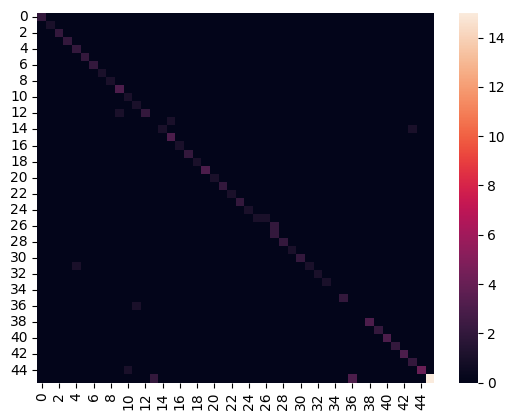

In [96]:
sns.heatmap(T.getAttr("x"))
plt.show()

Print two objectives separatelly:

In [97]:
print("Total cost=", (np.minimum(T.getAttr("x"), 1)*cost).sum().sum())
print("Total loss=", loss_cost*np.maximum(shortage - T.getAttr("x").sum(axis = 0), 0).sum())

Total cost= 8.222232540621967
Total loss= 1.576958544705076e-06


Total cost and loss:

In [98]:
my_model.objVal

8.22223247695459

The revenue that we get with transition matrix:

In [99]:
print("Total profit=", loss_cost*np.minimum(T.getAttr("x").sum(axis = 0), shortage).sum())

Total profit= 242.99999842304146


The revenue, cost and loss if we do not transfer the bikes at all

In [100]:
T_0 = np.diag(surplus)
print("Total profit(T=0)=", loss_cost*np.minimum(T_0.sum(axis = 0), shortage).sum())
print("Total cost(T=0)=", (np.minimum(T_0, 1)*cost).sum().sum())
print("Total loss(T=0)=", loss_cost*np.maximum(shortage - T_0.sum(axis = 0), 0).sum())

Total profit(T=0)= 210.0
Total cost(T=0)= 0.0
Total loss(T=0)= 33.0


The benefit of the optimization:

- If we do not transfer the bikes at all, the net income = 210-33 = 177
- If we transfer the bikes using optimization, the net income = 243-8.2 = 234.8

Extract the stations between which bikes have to be transfered:

In [101]:
transition_table = pd.DataFrame(T.getAttr("x"), index = stations.index, columns = stations.index)
transition_table_melt = transition_table.melt(ignore_index=False)
transition_table_melt = transition_table_melt.rename(columns = {"station":"to_station"})
transition_table_melt = transition_table_melt.reset_index()
transition_table_melt = transition_table_melt.rename(columns = {"station":"from_station"})
transition_table_melt = transition_table_melt[transition_table_melt.value.astype(int)!=0]
transition_table_melt = transition_table_melt[transition_table_melt.from_station!=transition_table_melt.to_station]
red_stations = transition_table_melt["to_station"].to_list() + transition_table_melt["from_station"].to_list()
transition_table_melt = transition_table_melt.set_index(["to_station", "from_station"])
transition_table_melt

,,value
to_station,from_station,
Norfolk St & Broome St,Grand St & Elizabeth St,1.000000
Broadway & W 58 St,11 Ave & W 41 St,1.000000
S 4 St & Wythe Ave,Broadway & Berry St,1.000000
W 22 St & 10 Ave,8 Ave & W 16 St,1.000000
Broadway & W 29 St,Inventory,1.999999
6 Ave & W 33 St,Broadway & W 29 St,1.000000
1 Ave & E 68 St,1 Ave & E 78 St,1.000000
1 Ave & E 62 St,1 Ave & E 68 St,2.000000
8 Ave & W 16 St,Inventory,3.000000


Distance between those stations:

In [102]:
dist_table = pd.DataFrame(dist_matrix, index = stations.index, columns = stations.index)
dist_table_melt = dist_table.melt(ignore_index=False)
dist_table_melt = dist_table_melt.rename(columns = {"station":"to_station"})
dist_table_melt = dist_table_melt.reset_index()
dist_table_melt = dist_table_melt.rename(columns = {"station":"from_station"})
dist_table_melt = dist_table_melt[dist_table_melt.from_station!=dist_table_melt.to_station]
dist_table_melt = dist_table_melt.set_index(["to_station", "from_station"])
dist_table_melt.loc[transition_table_melt.index]

,,value
to_station,from_station,
Norfolk St & Broome St,Grand St & Elizabeth St,0.008098
Broadway & W 58 St,11 Ave & W 41 St,0.018394
S 4 St & Wythe Ave,Broadway & Berry St,0.002568
W 22 St & 10 Ave,8 Ave & W 16 St,0.006571
Broadway & W 29 St,Inventory,0.008041
6 Ave & W 33 St,Broadway & W 29 St,0.002813
1 Ave & E 68 St,1 Ave & E 78 St,0.007921
1 Ave & E 62 St,1 Ave & E 68 St,0.004676
8 Ave & W 16 St,Inventory,0.019298


Map of stations and aproxinate transportations between

In [103]:
### Function to merge lists of sttations if they intersect: for beautiful visualization

def merge(lsts):
    sets = [set(lst) for lst in lsts if lst]
    merged = True
    while merged:
        merged = False
        results = []
        while sets:
            common, rest = sets[0], sets[1:]
            sets = []
            for x in rest:
                if x.isdisjoint(common):
                    sets.append(x)
                else:
                    merged = True
                    common |= x
            results.append(common)
        sets = results
    return [list(s) for s in sets]

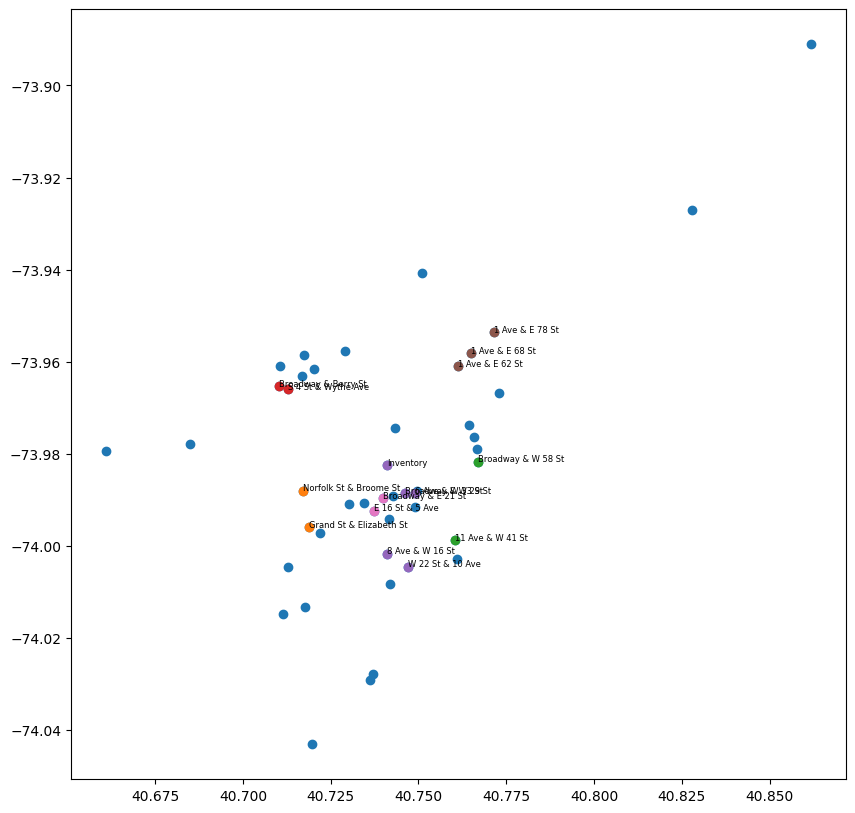

In [104]:
plt.figure(figsize = (10,10))
plt.scatter(stations.lat, stations.lon)
for l in merge(transition_table_melt.index):
    plt.scatter(stations.loc[l].lat, stations.loc[l].lon)
    for i in l:
        plt.annotate(i, (stations.loc[i].lat, stations.loc[i].lon), fontsize = 6)
plt.show()

## Conclusions:

1) With the mathematical optimization we managed to reduce the costs and loss and therefore increase the net income. 
2) The model is very flexible. You can add new constrains and set prices and objective that will fill your bussiness needs

## Future work:

1) We can add data about the number of bikes that have already been on the stations
2) Optimize the model in time
3) Can be used to decide where it is better to open a new station